# Baseline: ecapa

In [1]:
from speechbrain.nnet.losses import LogSoftmaxWrapper, AdditiveAngularMargin
from speechbrain.pretrained import EncoderClassifier
from data import create_dataloader
import torch
import numpy as np
from sklearn.metrics import classification_report, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import os
import matplotlib.pyplot as plt

## Configuration

In [2]:
model_name='spkrec-ecapa-voxceleb'
dir='utterance'
root=os.path.join('dataset',model_name,dir)

## Data preparation

In [ ]:
def augmentation(x):



In [3]:
def compute_features(model, loader, criterion):
    features=[]
    labels=[]
    lab2ind=model.hparams.label_encoder.lab2ind
    for i, data in enumerate(loader):
        x, label, y = data
        x = x.cuda()
        y = torch.tensor([[lab2ind[lab]] for lab in y]).cuda()
        with torch.inference_mode():
            pred, score, _, _ = model.encode_batch(x)
            loss = criterion(pred, y)
        features.append([loss,score])
        labels.append(label)
    return torch.tensor(features).numpy(), torch.tensor(labels).numpy()


In [4]:
if os.path.exists(root):
    train=np.load(os.path.join(root,'train.npy'))
    val=np.load(os.path.join(root,'val.npy'))
    test=np.load(os.path.join(root,'test.npy'))
else:
    os.makedirs(root)
    criterion=LogSoftmaxWrapper(AdditiveAngularMargin(margin=0.2, scale=30))
    model=EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", run_opts={"device": "cuda"})
    model.eval()
    train_loader, val_loader, test_loader = create_dataloader(
        root=os.path.join('split',dir),
        data_root='/home/baole/cmu/2023spring/11785/data/vox1/vox1_all/wav',
        batch_size=1
    )

    train_x, train_y=compute_features(model, train_loader, criterion)
    val_x, val_y=compute_features(model, val_loader, criterion)
    test_x, test_y=compute_features(model, test_loader, criterion)

    train=np.column_stack((train_x,train_y))
    np.save(os.path.join(root,'train.npy'),train)
    val=np.column_stack((val_x,val_y))
    np.save(os.path.join(root,'val.npy'),val)
    test=np.column_stack((test_x,test_y))
    np.save(os.path.join(root,'test.npy'),test)

/home/baole/miniconda3/envs/speechbrain/lib/python3.10/site-packages/torch/functional.py:641: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at /opt/conda/conda-bld/pytorch_1678411187366/work/aten/src/ATen/native/SpectralOps.cpp:862.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


## Visualization

In [5]:
def visualize(dataset):
    plt.scatter(dataset[:,0],dataset[:,1],c=dataset[:,2])
    plt.xlabel('loss')
    plt.ylabel('confidence')
    plt.show()

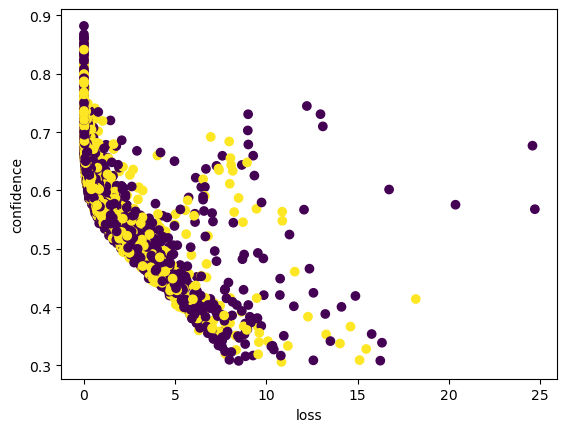

In [6]:
visualize(train)

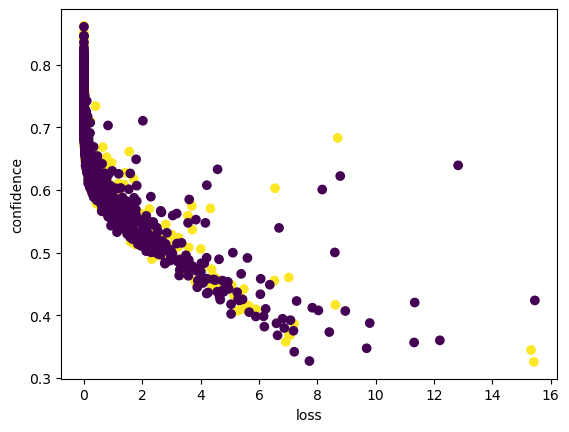

In [7]:
visualize(val)

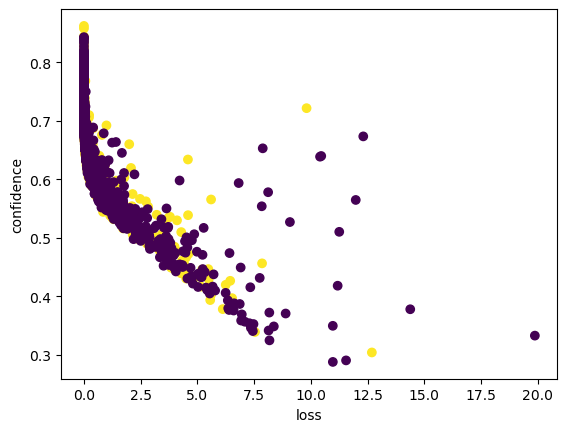

In [8]:
visualize(test)

## Evaluation

In [9]:
def classify(classifier, train, test):
    classifier.fit(train[:,:-1], train[:,-1])
    pred=classifier.predict(test[:,:-1])
    print(classification_report(test[:,-1],pred))
    RocCurveDisplay.from_estimator(classifier,test[:,:-1],test[:,-1])
    plt.show()

              precision    recall  f1-score   support

         0.0       0.55      0.40      0.46      2000
         1.0       0.53      0.68      0.59      2000

    accuracy                           0.54      4000
   macro avg       0.54      0.54      0.53      4000
weighted avg       0.54      0.54      0.53      4000



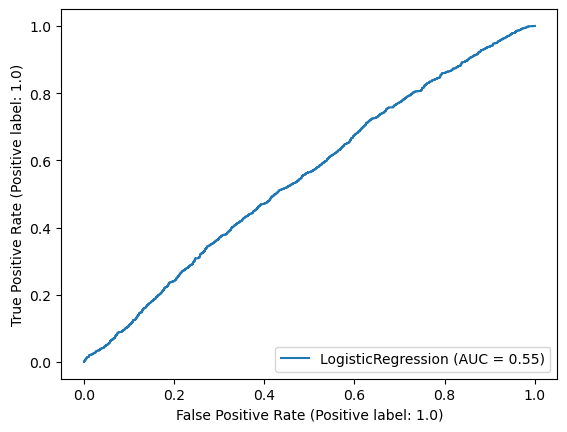

In [10]:
classify(LogisticRegression(),train,test)

              precision    recall  f1-score   support

         0.0       0.57      0.28      0.38      2000
         1.0       0.52      0.79      0.63      2000

    accuracy                           0.54      4000
   macro avg       0.55      0.54      0.50      4000
weighted avg       0.55      0.54      0.50      4000



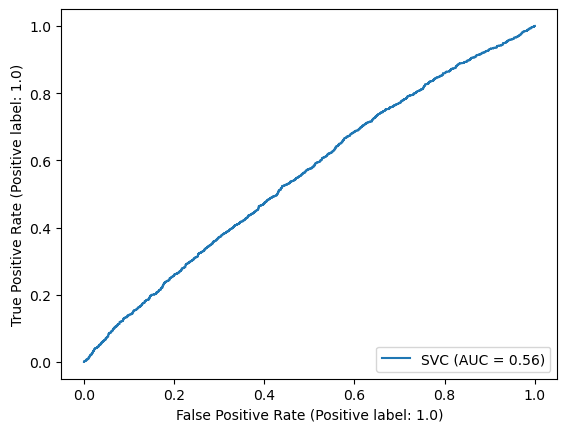

In [11]:
classify(SVC(),train,test)

              precision    recall  f1-score   support

         0.0       0.50      0.51      0.51      2000
         1.0       0.51      0.50      0.50      2000

    accuracy                           0.51      4000
   macro avg       0.51      0.51      0.50      4000
weighted avg       0.51      0.51      0.50      4000



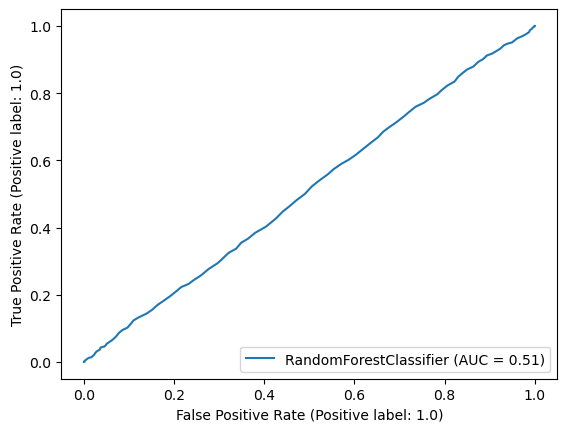

In [12]:
classify(RandomForestClassifier(),train,test)

              precision    recall  f1-score   support

         0.0       0.56      0.32      0.40      2000
         1.0       0.52      0.75      0.62      2000

    accuracy                           0.53      4000
   macro avg       0.54      0.53      0.51      4000
weighted avg       0.54      0.53      0.51      4000



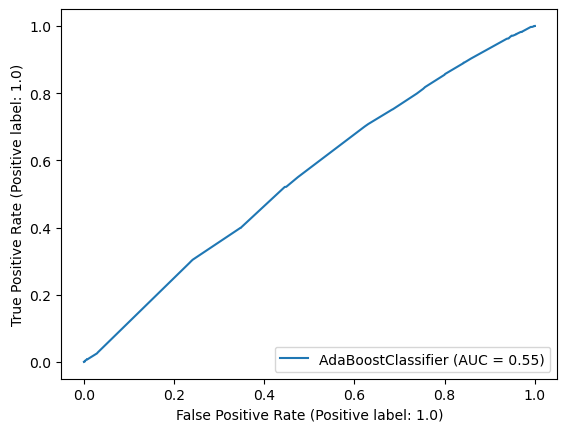

In [13]:
classify(AdaBoostClassifier(),train,test)

              precision    recall  f1-score   support

         0.0       0.56      0.36      0.44      2000
         1.0       0.53      0.71      0.60      2000

    accuracy                           0.54      4000
   macro avg       0.54      0.54      0.52      4000
weighted avg       0.54      0.54      0.52      4000



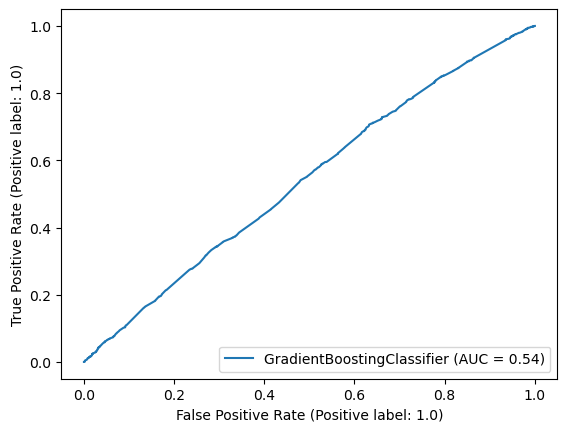

In [14]:
classify(GradientBoostingClassifier(),train,test)

              precision    recall  f1-score   support

         0.0       0.57      0.33      0.42      2000
         1.0       0.53      0.75      0.62      2000

    accuracy                           0.54      4000
   macro avg       0.55      0.54      0.52      4000
weighted avg       0.55      0.54      0.52      4000



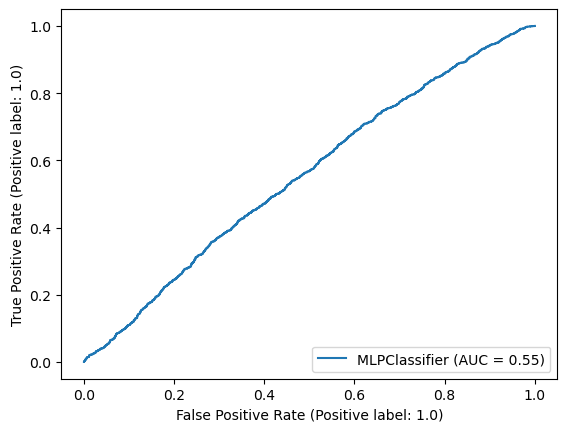

In [15]:
classify(MLPClassifier(),train,test)